In [ ]:
import csv
import codecs
import argparse
import os
from pathlib import Path
import pandas as pd
import sys, argparse
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import gc
from spacy.lang.en import English
from nltk.stem.porter import *
import re
import string
from tqdm import tqdm
import numpy as np
from scipy.sparse import coo_matrix, vstack
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup

In [ ]:
path = '/content/drive/MyDrive/DATA641 Final Project/nlp_project_data/umd_reddit_suicidewatch_dataset_v2/'

# **Functions**

In [ ]:
def normalize_tokens(tokenlist):
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@")                       # ignore  handles
                        ]
    return normalized_tokens    

def ngrams(tokens, n):
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def filter_punctuation_bigrams(ngrams):
    punct = string.punctuation
    return [ngram   for ngram in ngrams   if ngram[0] not in punct and ngram[1] not in punct]

def filter_stopword_bigrams(ngrams, stopwords):
    result = [ngram   for ngram in ngrams   if ngram[0] not in stopwords and ngram[1] not in stopwords]
    return result

In [ ]:
def convert_text_into_features(X, stopwords_arg, analyzefn="word", range=(1,2)):
    training_vectorizer = CountVectorizer(stop_words=stopwords_arg,
                                          analyzer=analyzefn,
                                          lowercase=True,
                                          ngram_range=range)
    X_features = training_vectorizer.fit_transform(X)
    return X_features, training_vectorizer

def convert_lines_to_feature_strings(lines, stopwords, remove_stopword_bigrams=True):

    print(" Converting from raw text to unigram and bigram features")
    if remove_stopword_bigrams:
        print(" Includes filtering stopword bigrams")
        
    print(" Initializing")
    stemmer = PorterStemmer()
    nlp          = English(parser=False)
    all_features = []
    print(" Iterating through documents extracting unigram and bigram features")
    for line in tqdm(lines):
        
        # Get spacy tokenization and normalize the tokens
        spacy_analysis    = nlp(line)
        spacy_tokens      = [token.orth_ for token in spacy_analysis]
        spacy_tokens      = [stemmer.stem(token) for token in spacy_tokens]
        normalized_tokens = normalize_tokens(spacy_tokens)

        # Collect unigram tokens as features
        # Exclude unigrams that are stopwords or are punctuation strings (e.g. '.' or ',')
        unigrams          = [token   for token in normalized_tokens
                                 if token not in stopwords and token not in string.punctuation]

        # Collect string bigram tokens as features
        bigrams = []
        bigram_tokens     = ["_".join(bigram) for bigram in bigrams]
        bigrams           = ngrams(normalized_tokens, 2) 
        bigrams           = filter_punctuation_bigrams(bigrams)
        if remove_stopword_bigrams:
            bigrams = filter_stopword_bigrams(bigrams, stopwords)
        bigram_tokens = ["_".join(bigram) for bigram in bigrams]

        # Collect string trigram tokens as features
        trigrams = []
        trigram_tokens     = ["_".join(trigram) for trigram in trigrams]
        trigrams           = ngrams(normalized_tokens, 3) 
        trigrams           = filter_punctuation_bigrams(trigrams)
        if remove_stopword_bigrams:
           trigrams = filter_stopword_bigrams(trigrams, stopwords)
        trigram_tokens = ["_".join(trigram) for trigram in trigrams]

        # Conjoin the feature lists and turn into a space-separated string of features.
        # E.g. if unigrams is ['coffee', 'cup'] and bigrams is ['coffee_cup', 'white_house']
        # then feature_string should be 'coffee cup coffee_cup white_house'
        
        unigrams = " ".join(unigrams)
        bigram_tokens = " ".join(bigram_tokens)
        trigram_tokens = " ".join(trigram_tokens)
        feature_string = " ".join([unigrams, bigram_tokens,trigram_tokens]) 

        # Add this feature string to the output
        all_features.append(feature_string)


    print(" Feature string for first document: '{}'".format(all_features[0]))
        
    return all_features

def most_informative_features(vectorizer, classifier, n=20):
    # Adapted from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers#11116960
    feature_names       = vectorizer.get_feature_names()
    coefs_with_features = sorted(zip(classifier.coef_[0], feature_names))
    top                 = zip(coefs_with_features[:n], coefs_with_features[:-(n + 1):-1])
    for (coef_1, feature_1), (coef_2, feature_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, feature_1, coef_2, feature_2))

In [ ]:
def load_stopwords(filename):
    stopwords = []
    with codecs.open(filename, 'r', encoding='ascii', errors='ignore') as fp:
        stopwords = fp.read().split('\n')
    return set(stopwords)

stopwords = load_stopwords(path+'mallet_en_stoplist.txt')   

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]/,.!?]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# **Loading Data**

In [ ]:
crowd_train = pd.read_csv(path+'crowd/train/crowd_train.csv')
task_A_train = pd.read_csv(path+'crowd/train/task_A_train.posts.csv')
task_B_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
task_C_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
shared_task_train = pd.read_csv(path+'crowd/train/shared_task_posts.csv')

In [ ]:
crowd_test = pd.read_csv(path+'crowd/test/crowd_test.csv')
task_A_test = pd.read_csv(path+'crowd/test/task_A_test.posts.csv')
task_B_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
task_C_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
shared_task_test = pd.read_csv(path+'crowd/test/shared_task_posts_test.csv')

In [ ]:
label = np.array(['a','b','c','d'])
c = np.array(['Negative','Negative','Negative','Positive'])

d = np.vstack([label,c])

df_class = pd.DataFrame(data=d.T,columns=['label','class'])

df_class

,label,class
0,a,Negative
1,b,Negative
2,c,Negative
3,d,Positive


# **Task A**

Training and testing logistic regreassion, decision tress, and support vector machine using data long from the subreddit 'SuicideWatch'

In [ ]:
df_A_train = shared_task_train[shared_task_train['subreddit'] == 'SuicideWatch']
df_A_train = df_A_train.dropna()

In [ ]:
df_A_train = pd.merge(df_A_train,crowd_train,on='user_id')

df_A_train = pd.merge(df_A_train,df_class,on='label')

In [ ]:
# piling the post title and its correponding post body into one string
# forming a new datafram which one column is piled strings and another is classes

A_train = pd.DataFrame(data=None,columns = ['text','class'])

A_train['text'] = df_A_train['post_title']+' '+ df_A_train['post_body']

A_train['class'] = df_A_train['class']

A_train['text'] = normalize_tokens(A_train['text'])
A_train['text'] = A_train['text'].apply(denoise_text)
# some urls and random puntuations are still found in the data; hence the extra denoising  

In [ ]:
df_A_test = shared_task_test[shared_task_test['subreddit'] == 'SuicideWatch']
df_A_test = df_A_test.dropna()

df_A_test = pd.merge(df_A_test,crowd_test,on='user_id')

df_A_test['label'] = df_A_test['raw_label']

df_A_test = pd.merge(df_A_test,df_class,on='label')

In [ ]:
A_test = pd.DataFrame(data=None,columns = ['text','class'])

A_test['text'] = df_A_test['post_title']+' '+ df_A_test['post_body']

A_test['class'] = df_A_test['class']

A_test['text'] = normalize_tokens(A_test['text'])
A_test['text'] = A_test['text'].apply(denoise_text)


In [ ]:
X_train = convert_lines_to_feature_strings(A_train['text'],stopwords)

In [ ]:
X_train, training_vectorizer = convert_text_into_features(X_train,stopwords)

In [ ]:
X_test = convert_lines_to_feature_strings(A_test['text'],stopwords)
X_test = training_vectorizer.transform(X_test)

In [ ]:
data_A = pd.concat([A_train,A_test],axis=0)

In [ ]:
x = convert_lines_to_feature_strings(data_A['text'],stopwords)

### **Logistic Regression (unigram+bigram+trigram strings)**

In [ ]:
lr_classifier = LogisticRegression(solver='liblinear')
lr_classifier.fit(X_train, A_train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer,lr_classifier,20)

	-0.7021	url            		0.6552	dead           
	-0.4823	friend         		0.4746	aliv           
	-0.4681	advic          		0.4457	plan           
	-0.4350	hour           		0.4456	pain           
	-0.3836	ll             		0.3915	suck           
	-0.3831	talk           		0.3774	kill           
	-0.3555	bad            		0.3755	fuck           
	-0.3490	anymor talk    		0.3745	world          
	-0.3311	thing          		0.3474	end            
	-0.3248	anymor_talk    		0.3298	cut            
	-0.3248	talk anymor_talk		0.2977	noth           
	-0.3190	respond        		0.2853	care           
	-0.3128	link           		0.2760	explain_someone
	-0.3046	matter         		0.2734	tire           
	-0.2818	reddit post    		0.2703	t_anymor       
	-0.2757	sad            		0.2694	wait           
	-0.2722	joy            		0.2632	wake           
	-0.2652	realli         		0.2610	final          
	-0.2554	post realli    		0.2533	knife          
	-0.2554	smile reddit   		0.2507	pill           


In [ ]:
lr_classifier.score(X_test,A_test['class'])

0.569060773480663

In [ ]:
X_features,_ = convert_text_into_features(x,stopwords)

In [ ]:
accuracy_scores = cross_val_score(lr_classifier, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.63265306 0.55685131 0.59064327], mean = 0.5933825493438812, stdev = 0.031006494122899304


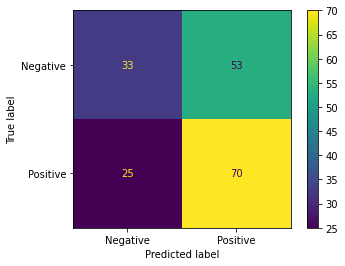

In [ ]:
metrics.plot_confusion_matrix(lr_classifier,X_test,A_test['class'])

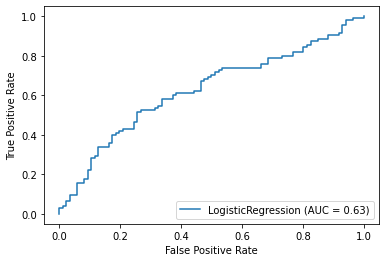

In [ ]:
metrics.plot_roc_curve(lr_classifier, X_test, A_test['class'])

**Testing the Logistic Regression classifier using wild data (all the data but suicide watch)**

In [ ]:
df_wild_train = shared_task_train[shared_task_train['subreddit'] != 'SuicideWatch']
df_wild_test = shared_task_test[shared_task_test['subreddit'] != 'SuicideWatch']

df_wild = pd.concat([df_wild_train,df_wild_test],axis=0)
df_wild = df_wild.dropna()

df_wild = pd.merge(df_wild,crowd_train,on='user_id')

df_wild = pd.merge(df_wild,df_class,on='label')

In [ ]:
wild_text = df_wild['post_title']+' '+ df_wild['post_body']

wild_class = df_wild['class']

norm_txt = normalize_tokens(wild_text)

norm_txt = pd.DataFrame(data=norm_txt,columns = ['text'])

wild_data = pd.concat([norm_txt,wild_class], ignore_index=True, axis=1)
wild_data = wild_data.dropna()
wild_data.columns = ['text','class']
wild_data['text'] = wild_data['text'].apply(denoise_text)

In [ ]:
x_wild = convert_lines_to_feature_strings(wild_data['text'],stopwords)

In [ ]:
x_wild_features = training_vectorizer.transform(x_wild)

In [ ]:
accuracy_scores = cross_val_score(lr_classifier, x_wild_features, 
                                  wild_data['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy scores = [0.53970672 0.5458008  0.53238095], mean = 0.5392961582525475, stdev = 0.005486316236856606


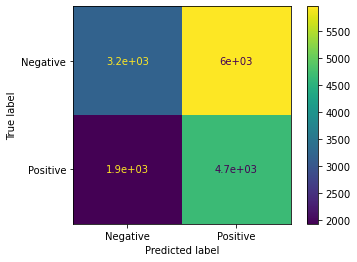

In [ ]:
metrics.plot_confusion_matrix(lr_classifier,x_wild_features,wild_data['class'])

### **Decision Trees**

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train,A_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree.score(X_test,A_test['class'])

0.5359116022099447

In [ ]:
accuracy_scores = cross_val_score(tree, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.60641399 0.59766764 0.54093567], mean = 0.5816724350558937, stdev = 0.029025707584838217


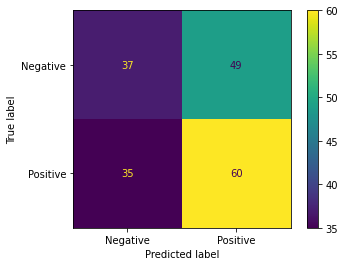

In [ ]:
metrics.plot_confusion_matrix(tree,X_test,A_test['class'])

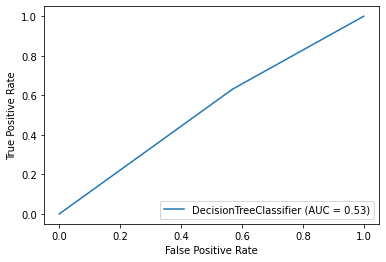

In [ ]:
metrics.plot_roc_curve(tree, X_test,A_test['class'])

### **SVM**

In [ ]:
svm_a = svm.SVC()
svm_a.fit(X_train,A_train['class'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm_a.score(X_test,A_test['class'])

0.5248618784530387

In [ ]:
accuracy_scores = cross_val_score(svm_a, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.58017493 0.58017493 0.5877193 ], mean = 0.5826897174910065, stdev = 0.0035564506581083964


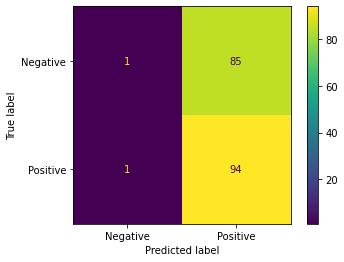

In [ ]:
metrics.plot_confusion_matrix(svm_a,X_test,A_test['class'])

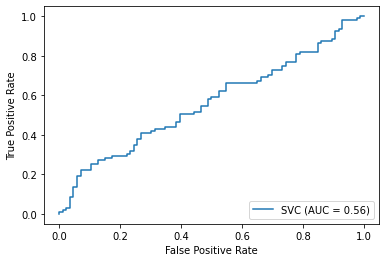

In [ ]:
metrics.plot_roc_curve(svm_a, X_test,A_test['class'])

# **Task B**

using every post titles and post bodies as training and testing data

In [ ]:
df_B_train = shared_task_train
df_B_train = df_B_train.dropna()
df_B_train = pd.merge(df_B_train,crowd_train,on='user_id')
df_B_train = pd.merge(df_B_train,df_class, on = 'label')

In [ ]:
data_task_b_class = pd.DataFrame(data=df_B_train['class'],columns = ['class'])

task_b_text = df_B_train['post_title']+' '+ df_B_train['post_body']
task_b_text = normalize_tokens(task_b_text)

data_task_b_text = pd.DataFrame(data=task_b_text,columns = ['text'])

B_train = pd.concat([data_task_b_text,data_task_b_class],ignore_index=True, axis=1)
B_train = B_train.dropna()
B_train.columns = ['text','class']

In [ ]:
df_B_test = shared_task_test
df_B_test = df_B_test.dropna()
df_B_test = pd.merge(df_B_test,crowd_test,on='user_id')
df_B_test['label'] = df_B_test['raw_label']
df_B_test = pd.merge(df_B_test,df_class, on = 'label')

data_task_b_class = pd.DataFrame(data=df_B_test['class'],columns = ['class'])

task_b_text = df_B_test['post_title']+' '+ df_B_test['post_body']
task_b_text = normalize_tokens(task_b_text)

data_task_b_text = pd.DataFrame(data=task_b_text,columns = ['text'])

B_test = pd.concat([data_task_b_text,data_task_b_class],ignore_index=True, axis=1)
B_test = B_test.dropna()
B_test.columns = ['text','class']

In [ ]:
X_train_b = convert_lines_to_feature_strings(B_train['text'],stopwords)

In [ ]:
X_train_b, training_vectorizer_b = convert_text_into_features(X_train_b,stopwords)

In [ ]:
X_test_b =  convert_lines_to_feature_strings(B_test['text'],stopwords)
X_test_b_features = training_vectorizer_b.transform(X_test_b)

### **Logistic Regression**

In [ ]:
lr_classifier_b = LogisticRegression(solver='liblinear')
lr_classifier_b.fit(X_train_b, B_train['class'])

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer_b,lr_classifier_b,20)

	-0.4731	bike           		0.5348	ps4            
	-0.3372	tree           		0.4550	voic           
	-0.3183	twin           		0.3365	psn            
	-0.3044	stream         		0.3160	amiibo         
	-0.2629	cancer         		0.3097	mum            
	-0.2605	iv             		0.3097	vegan          
	-0.2582	hey            		0.3094	war            
	-0.2552	mile           		0.3069	contest        
	-0.2516	fit            		0.3046	fail           
	-0.2388	lift           		0.3009	friendship     
	-0.2321	gener          		0.2774	upset          
	-0.2311	halo           		0.2763	thealderbunni  
	-0.2286	ride           		0.2763	psn thealderbunni
	-0.2275	season         		0.2649	piec           
	-0.2232	poni           		0.2467	32             
	-0.2197	yeah           		0.2453	manag          
	-0.2158	deck           		0.2429	instal         
	-0.2138	area           		0.2364	appar          
	-0.2128	husband        		0.2351	weird          
	-0.2108	pull           		0.2325	seri           


In [ ]:
lr_classifier_b.score(X_test_b_features,B_test['class'])

0.5385242560130452

In [ ]:
X_features_b = vstack([X_train_b,X_test_b_features])
data_B = pd.concat([B_train,B_test],axis=0)

In [ ]:
accuracy_scores_b = cross_val_score(lr_classifier_b, X_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy scores = [0.54233505 0.52887835 0.57324219], mean = 0.5481518631392437, stdev = 0.018572632429670388


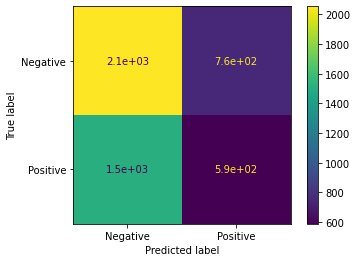

In [ ]:
metrics.plot_confusion_matrix(lr_classifier_b,X_test_b_features,B_test['class'])

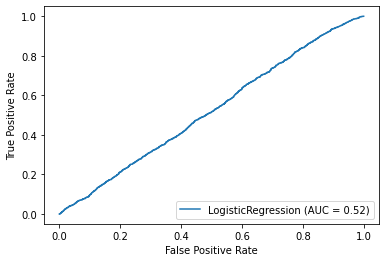

In [ ]:
metrics.plot_roc_curve(lr_classifier_b, X_test_b_features,B_test['class'])

### **Decision Trees**

In [ ]:
tree_b = DecisionTreeClassifier(criterion='entropy')
tree_b.fit(X_train_b, B_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree_b.score(X_test_b_features,B_test['class'])

0.5299633102323685

In [ ]:
accuracy_scores = cross_val_score(tree_b, X_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

accuracy scores = [0.54233505 0.52887835 0.57324219], mean = 0.5481518631392437, stdev = 0.018572632429670388


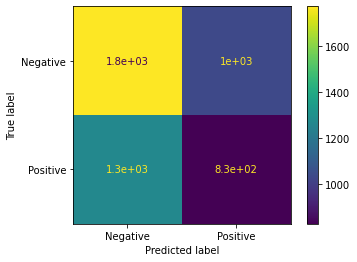

In [ ]:
metrics.plot_confusion_matrix(tree_b,X_test_b_features,B_test['class'])

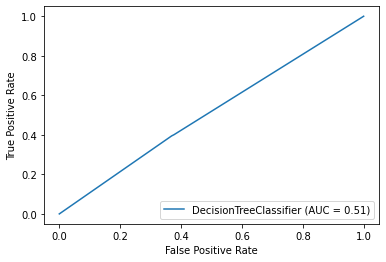

In [ ]:
metrics.plot_roc_curve(tree_b, X_test_b_features,B_test['class'])

### **SVM**

In [ ]:
svm_b = svm.SVC()
svm_b.fit(X_train_b, B_train['class'])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svm_b.score(X_test_b_features,B_test['class'])

In [ ]:
accuracy_scores = cross_val_score(svm_b, X_features_b, 
                                  data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

In [ ]:
metrics.plot_confusion_matrix(svm_b,X_test_b_features,B_test['class'])

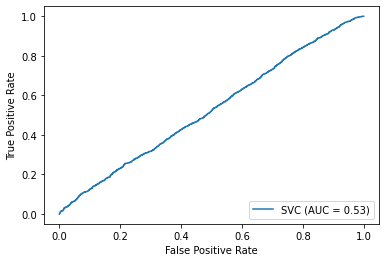

In [ ]:
metrics.plot_roc_curve(svm_b, X_test_b_features,B_test['class'])